In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.externals import joblib
import matplotlib.patches as patches

from helpfunction import sciNot

%matplotlib inline
gr      = 1.618

In [2]:
min_dedx_hits=3
min_reco_e=0.03
z_dead_start = 675
z_dead_end=z_dead_start+100

mu_cutoff=5 #0.5

pd.options.display.max_columns = 999

input_dir = "../Input/dev_set/"
output_dir = "../Output/Track_Shower_tune3/"

In [3]:
def insertscore(df,model,columns_train,name):
    df[name]    = model.predict_proba(df[columns_train].as_matrix())[:,1]
    return df

def insertscores(df,columns,columns_mu,tr_or_sh):
    files = glob.glob(input_dir+"XGBoost/*.pkl")
    names = [file.split("/")[-1].split(".")[0][6:] for file in files]
    models = [joblib.load(file) for file in files]
    for name,model in zip(names,models):
        if tr_or_sh in name:
            if "mu" in name:
                df = insertscore(df,model,columns_mu,name)
            else:
                df = insertscore(df,model,columns,name)
    return df


#The statistical uncertainity per bin of the binned data.
#If there are weights then the uncertainity will be the root of the
#sum of the weights squared.
def hist_bin_uncertainty(data, weights, bin_edges):
    # Bound the data and weights to be within the bin edges
    in_range_index = [idx for idx in range(len(data)) if data[idx] > min(bin_edges) and data[idx] < max(bin_edges)]
    in_range_data = np.asarray([data[idx] for idx in in_range_index])
    in_range_weights = np.asarray([weights[idx] for idx in in_range_index])

    # Bin the weights with the same binning as the data
    bin_index = np.digitize(in_range_data, bin_edges)
    # N.B.: range(1, bin_edges.size) is used instead of set(bin_index) as if
    # there is a gap in the data such that a bin is skipped no index would appear
    # for it in the set
    binned_weights = np.asarray(
        [in_range_weights[np.where(bin_index == idx)[0]] for idx in range(1, len(bin_edges))])
    bin_uncertainties = np.asarray(
        [np.sqrt(np.sum(np.square(w))) for w in binned_weights])
    return bin_uncertainties

# Tracks

In [4]:
# Tune1

input_tr = [input_dir+"lee_75k/lee_75k_track_9.pckl",
            input_dir+"intime/intime_track_7.pckl",
            
            input_dir+"nue_tune3/nue_tune3_track_0.pckl",
            #input_dir+"nue_tune3/nue_tune3_track_1.pckl",
            #input_dir+"nue_tune3/nue_tune3_track_2.pckl",
            #input_dir+"nue_tune3/nue_tune3_track_3.pckl",
            #input_dir+"nue_tune3/nue_tune3_track_4.pckl",
            
            #input_dir+"nu_tune3/nu_tune3_track_4.pckl",
            #input_dir+"nu_tune3/nu_tune3_track_5.pckl",
            input_dir+"nu_tune3/nu_tune3_track_0.pckl",
            input_dir+"nu_tune3/nu_tune3_track_1.pckl",
           ]

input_test = [#input_dir+"nu_tune3/nu_tune3_track_0.pckl",
              #input_dir+"nu_tune3/nu_tune3_track_1.pckl",
              input_dir+"nu_tune3/nu_tune3_track_2.pckl",
              input_dir+"nu_tune3/nu_tune3_track_3.pckl",
           ]


In [5]:
#input_tr_data = [input_dir+"XGBoost/bnb/trackFrame_data_bnb.pckl",
#                 input_dir+"XGBoost/bnbext/trackFrame_data_bnbext.pckl"
#                ]

intput_tr_df = [ pd.read_pickle(x) for x in input_tr]
df_tr_train = pd.concat(intput_tr_df,ignore_index=True,copy=False) 

intput_tr_df = [ pd.read_pickle(x) for x in input_test]
df_tr_test = pd.concat(intput_tr_df,ignore_index=True,copy=False) 


# Do some things before training on the frame
df_tr_train = pd.get_dummies(df_tr_train,columns=["track_is_daughter","track_daughter"],drop_first=True)
df_tr_train["true_mu"] = df_tr_train["matched_tracks"].abs() == 13
df_tr_train["true_e"] = df_tr_train["matched_tracks"] == 11


# Do some things before testing on the frame
print("train",df_tr_train.columns)
print("test",df_tr_test.columns)
df_tr_test = pd.get_dummies(df_tr_test,columns=["track_is_daughter","track_daughter"],drop_first=True)

df_tr_test["true_mu"] = df_tr_test["matched_tracks"].abs() == 13
df_tr_test["true_e"] = df_tr_test["matched_tracks"] == 11


columns_track_XGB =       ["track_vtxdistance", "track_maxangle",
                           "track_spacepoint_dqdx_ratio", "predict_cos", "track_pca",
                           "track_dedx_best_w",
                           "predict_mu", "predict_pi",
                           "track_dedx_hits_w", "predict_p",
                           "track_dedx_w",
                           "track_hitsratio_w", "predict_em", 
                           "track_len"
                          ]

columns_track_XGB_mu = columns_track_XGB+["track_hits_w"]

FileNotFoundError: [Errno 2] No such file or directory: '../Input/dev_set/lee_75k/lee_75k_track_9.pckl'

In [ ]:
df_tr_train.head()

In [ ]:
# For now, quick fix: require at least x hits in track_dedx_hits, otherwise track_dedx is nonsence.
# Also require a reconstructed energy of at leact x Mev
df_tr_train = df_tr_train[df_tr_train["track_dedx_hits_w"]>=min_dedx_hits]
df_tr_test = df_tr_test[df_tr_test["track_dedx_hits_w"]>=min_dedx_hits]
df_tr_train = df_tr_train[df_tr_train["track_energy_w"]>=min_reco_e]
df_tr_test = df_tr_test[df_tr_test["track_energy_w"]>=min_reco_e]
df_tr_train = df_tr_train[~df_tr_train["track_start_z"].between(z_dead_start,z_dead_end)]
df_tr_test = df_tr_test[~df_tr_test["track_start_z"].between(z_dead_start,z_dead_end)]

df_tr_train.head()
print(df_tr_train.columns)

In [ ]:
X_train = df_tr_train[columns_track_XGB].as_matrix()
X_test  = df_tr_test[columns_track_XGB].as_matrix()

X_train_mu = df_tr_train[columns_track_XGB_mu].as_matrix()
X_test_mu  = df_tr_test[columns_track_XGB_mu].as_matrix()

Y_train = df_tr_train[["true_mu","true_e","track_cle"]]
Y_test = df_tr_test[["true_mu","true_e","track_cle"]]

In [ ]:
# fit model no training data
label = "true_mu"
model = XGBClassifier()
model.fit(X_train_mu, Y_train[label])
print(classification_report(Y_test[label], model.predict(X_test_mu)))
joblib.dump(model, input_dir+"XGBoost/model_tr_mu.pkl") 
y_pred_mu = model.predict_proba(X_test_mu)
y_pred_mu_train = model.predict_proba(X_train_mu)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB_mu)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB_mu[indices[f]],importances[indices[f]]))

In [ ]:
# fit model no training data
label = "true_e"
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<mu_cutoff], Y_train[label][y_pred_mu_train[:,1]<mu_cutoff])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, input_dir+"XGBoost/model_tr_e.pkl") 
y_pred_e = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

In [ ]:
# fit model no training data
label = "track_cle"
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<mu_cutoff], Y_train[label][y_pred_mu_train[:,1]<mu_cutoff])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, input_dir+"XGBoost/model_tr_cle.pkl") 
y_pred_cle = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

In [ ]:
# XGB classification

plt.style.use("default")
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r"XGBoost muon/electron track classifier (test dataset)")
N=50
muon_cut = 0.05
electron_cut=0.7
close_e_cut=0.7


# Electron track classification
y_test_e = Y_test["true_e"]
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron track classification
y_test_cle = Y_test["track_cle"]
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon track classification
y_test_mu = Y_test["true_mu"]
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r"$\mu^+/ \:\mu^-$ matched ("+str(len(arr_mu))+")","Other ("+str(len(arr_nmu))+")")
label_e=(r"$e^-$ matched ("+str(len(arr_e))+")","Other ("+str(len(arr_ne))+")")
label_cl_e=(r"$e^-$ closest ("+str(len(arr_cl_e))+")","Other ("+str(len(arr_cl_ne))+")")

ax[0][0].axvspan(muon_cut,1, alpha=0.15, color="red",label="Rejected objects > "+str(muon_cut) )
ax[0][0].hist([arr_mu,arr_nmu],histtype="step", bins=N, fill=False,label=label_mu,density=True)
ax[0][0].set_ylabel("Normalised")


ax[1][0].axvspan(muon_cut,1, alpha=0.15, color="red",label="Rejected objects > "+str(muon_cut) )
ax[1][0].hist([arr_mu,arr_nmu],histtype="step", bins=N, fill=False,label=label_mu,density=True)
ax[1][0].set_ylim(0,5)
ax[1][0].set_ylabel("Normalised")
ax[1][0].set_xlabel("PID Probability")

ax[0][1].axvspan(electron_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(electron_cut) )
ax[0][1].hist([arr_e,arr_ne],histtype="step", bins=N, fill=False,label=label_e,density=True)

ax[1][1].axvspan(electron_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(electron_cut) )
ax[1][1].hist([arr_e,arr_ne],histtype="step", bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,3)
ax[1][1].set_xlabel("Probability")


ax[0][2].axvspan(close_e_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(close_e_cut) )
ax[0][2].hist([arr_cl_e,arr_cl_ne],histtype="step", bins=N, fill=False,label=label_cl_e,density=True)

ax[1][2].axvspan(close_e_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(close_e_cut) )
ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype="step", bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,3)
ax[1][2].set_xlabel("Probability")

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc="upper center")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper center")
handles, labels = ax[0][2].get_legend_handles_labels()
ax[0][2].legend(handles[::-1], labels[::-1],loc="upper center")

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig(output_dir+"XGB_track.pdf")

print("Cut value:",muon_cut,"removes", sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),"% of muon tagged tracks and",
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),"% of not-muon tagged tracks.")

print("Cut value:",electron_cut,"keeps", sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),"% of electron tagged tracks and",
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),"% of not-electron tagged tracks.")

print("Cut value:",close_e_cut,"keeps", sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),"% of closest electron tagged tracks and",
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),"% of not-closest-electron tagged tracks.")


# Showers

In [ ]:
input_sh = [#input_dir+"intime/intime_shower_0.pckl",
            input_dir+"/nue/nue_shower_0.pckl",
            input_dir+"/nu/nu_shower_0.pckl",
           ]

input_test = [#input_dir+"nu_tune3/nu_tune3_shower_0.pckl",
              #input_dir+"nu_tune3/nu_tune3_shower_1.pckl",
               input_dir+"/nue/nue_shower_0.pckl",
            input_dir+"/nu/nu_shower_0.pckl",
           ]


#input_sh_data = [input_dir+"XGBoost/bnb/showerFrame_data_bnb.pckl",
#                 input_dir+"XGBoost/bnbext/showerFrame_data_bnbext.pckl"
#                ]

intput_sh_df = [ pd.read_pickle(x) for x in input_sh]
df_sh_train = pd.concat(intput_sh_df,ignore_index=True,copy=False) 
#df_sh_train_lee = pd.read_pickle(input_dir+"lee_75k/lee_75k_shower_9.pckl")
df_sh_train["bnbweight"]=1
#df_sh_train_lee["bnbweight"]=10
df_sh_train= pd.concat([df_sh_train],ignore_index=True,copy=False) 

intput_sh_df = [ pd.read_pickle(x) for x in input_test]
df_sh_test = pd.concat(intput_sh_df,ignore_index=True,copy=False) 

# Do some things before training on the frame
df_sh_train = pd.get_dummies(df_sh_train,columns=["shower_is_daughter","shower_daughter"],drop_first=True)
df_sh_train["true_mu"] = df_sh_train["matched_showers"].abs() == 13
df_sh_train["true_e"] = df_sh_train["matched_showers"] == 11


# Do some things before training on the frame
df_sh_test = pd.get_dummies(df_sh_test,columns=["shower_is_daughter","shower_daughter"],drop_first=True)
df_sh_test["true_mu"] = df_sh_test["matched_showers"].abs() == 13
df_sh_test["true_e"] = df_sh_test["matched_showers"] == 11

columns_shower_XGB  = ["shower_open_angle","shower_length","n_showers",
                       "shower_pca", "shower_maxangle","shower_vtxdistance",
                       "shower_fidvol_ratio","shower_spacepoint_dqdx_ratio",
                       "shower_dedx_hits_w","shower_dedx_w","shower_dedx_best_w","shower_hitsratio_w",
                       #"vtx_activity","shower_is_daughter_2",
                       #"shower_is_daughter_1", "shower_daughter_1", "shower_daughter_2", #"shower_daughter_3",
                       #"shower_energy_w", ,"shower_hits_w", "shower_theta","shower_energy_product"
                      ]

columns_shower_XGB_mu = columns_shower_XGB+["shower_hits_w"]

In [ ]:
df_sh_train.head()

In [ ]:
# For now, quick fix: require at least x hits in shower_dedx_hits, otherwise shower_dedx is nonsence.
# Also require a reconstructed energy of at leact x Mev
df_sh_train = df_sh_train[df_sh_train["shower_dedx_hits_w"]>=min_dedx_hits]
df_sh_test = df_sh_test[df_sh_test["shower_dedx_hits_w"]>=min_dedx_hits]
df_sh_train = df_sh_train[df_sh_train["shower_energy_w"]>=min_reco_e]
df_sh_test = df_sh_test[df_sh_test["shower_energy_w"]>=min_reco_e]
sf_sh_train = df_sh_train[~df_sh_train["shower_start_z"].between(z_dead_start,z_dead_end)]
df_sh_test = df_sh_test[~df_sh_test["shower_start_z"].between(z_dead_start,z_dead_end)]

df_sh_train.head()
print(df_sh_train.columns)

In [ ]:
X_train = df_sh_train[columns_shower_XGB].as_matrix()
X_test  = df_sh_test[columns_shower_XGB].as_matrix()

X_train_mu = df_sh_train[columns_shower_XGB_mu].as_matrix()
X_test_mu  = df_sh_test[columns_shower_XGB_mu].as_matrix()


X_train_weights = df_sh_train["bnbweight"]

Y_train = df_sh_train[["true_mu","true_e","shower_cle"]]
Y_test = df_sh_test[["true_mu","true_e","shower_cle"]]

In [ ]:
# fit model no training data
label = "true_mu"
model = XGBClassifier()
model.fit(X_train_mu, Y_train[label])
print(classification_report(Y_test[label],model.predict(X_test_mu)))
joblib.dump(model, input_dir+"XGBoost/model_sh_mu.pkl") 
y_pred_mu = model.predict_proba(X_test_mu)
y_pred_mu_train = model.predict_proba(X_train_mu)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB_mu)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB_mu[indices[f]],importances[indices[f]]))

In [ ]:
# fit model no training data
label = "true_e"
model = XGBClassifier()

print(X_train.shape)
print(y_pred_mu_train.size)
print( Y_train[label].size)

model.fit(X_train[y_pred_mu_train[:,1]<mu_cutoff], Y_train[label][y_pred_mu_train[:,1]<mu_cutoff])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, input_dir+"XGBoost/model_sh_e.pkl")
y_pred_e = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

In [ ]:
# fit model no training data
label = "shower_cle"
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<mu_cutoff], Y_train[label][y_pred_mu_train[:,1]<mu_cutoff])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, input_dir+"XGBoost/model_sh_cle.pkl") 
y_pred_cle = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

In [ ]:
# XGB classification

plt.style.use("default")
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r"XGBoost muon/electron shower classifier (test dataset)")
N=50
muon_cut = 0.07
electron_cut=0.90
close_e_cut=0.9

# Electron shower classification
y_test_e = Y_test["true_e"]
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron shower classification
y_test_cle = Y_test["shower_cle"]
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon shower classification
y_test_mu = Y_test["true_mu"]
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r"$\mu^+/\mu^-$ matched ("+str(len(arr_mu))+")","Other ("+str(len(arr_nmu))+")")
label_e=(r"$e^-$ matched ("+str(len(arr_e))+")","Other ("+str(len(arr_ne))+")")
label_cl_e=(r"$e^-$ closest ("+str(len(arr_cl_e))+")","Other ("+str(len(arr_cl_ne))+")")


ax[0][0].axvspan(muon_cut,1, alpha=0.15, color="red",label="Rejected objects > "+str(muon_cut) )
ax[0][0].hist([arr_mu,arr_nmu],histtype="step", bins=N, fill=False,label=label_mu,density=True)
ax[0][0].set_ylabel("Normalised")


ax[1][0].axvspan(muon_cut,1, alpha=0.15, color="red",label="Rejected objects > "+str(muon_cut) )
ax[1][0].hist([arr_mu,arr_nmu],histtype="step", bins=N, fill=False,label=label_mu,density=True)
ax[1][0].set_ylim(0,3)
ax[1][0].set_ylabel("Normalised")
ax[1][0].set_xlabel("Probability")

ax[0][1].axvspan(electron_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(electron_cut) )
ax[0][1].hist([arr_e,arr_ne],histtype="step", bins=N, fill=False,label=label_e,density=True)

ax[1][1].axvspan(electron_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(electron_cut) )
ax[1][1].hist([arr_e,arr_ne],histtype="step", bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,3)
ax[1][1].set_xlabel("Probability")


ax[0][2].axvspan(close_e_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(close_e_cut) )
ax[0][2].hist([arr_cl_e,arr_cl_ne],histtype="step", bins=N, fill=False,label=label_cl_e,density=True)

ax[1][2].axvspan(close_e_cut,1, alpha=0.15, color="green",label="Accepted objects > "+str(close_e_cut) )
ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype="step", bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,3)
ax[1][2].set_xlabel("Probability")

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc="upper center")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper center")
handles, labels = ax[0][2].get_legend_handles_labels()
ax[0][2].legend(handles[::-1], labels[::-1],loc="upper center")

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig((output_dir+"XGB_shower.pdf")

print("Cut value:",muon_cut,"removes", sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),"% of muon tagged shower and",
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),"% of not-muon tagged showers.")

print("Cut value:",electron_cut,"keeps", sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),"% of electron tagged shower and",
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),"% of not-electron tagged showers.")

print("Cut value:",close_e_cut,"keeps", sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),"% of closest electron tagged shower and",
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),"% of not-closest-electron tagged showers.")


In [ ]:
# fit model no training data
label = "shower_cle"
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5],sample_weight=X_train_weights[y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, input_dir+"XGBoost/model_sh_cle_lee.pkl") 
y_pred_cle_lee = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

## Track/Shower Heatmaps

In [ ]:
input_test = [input_dir+"nue_tune3/nue_tune3_shower_1.pckl",
              input_dir+"nue_tune3/nue_tune3_shower_2.pckl",
              #input_dir+"nue_tune3/nue_tune3_shower_7.pckl",
              #input_dir+"nue_tune3/nue_tune3_shower_8.pckl",
              #input_dir+"nue_tune3/nue_tune3_shower_9.pckl"
              ]

intput_sh_df = [ pd.read_pickle(x) for x in input_test]
df_sh_test = pd.concat(intput_sh_df,ignore_index=True,copy=False) 


# Do some things before testing on the frame
#df_tr_test = pd.get_dummies(df_tr_test,columns=["track_is_daughter","track_daughter"],drop_first=True)
df_sh_test["true_mu"] = df_sh_test["matched_showers"].abs() == 13
df_sh_test["true_e"] = df_sh_test["matched_showers"] == 11

columns_shower_map  = ["shower_vtxdistance","shower_dedx_w","shower_maxangle",
                       "shower_open_angle","shower_pca","shower_length",
                       "shower_dedx_hits_w","shower_hitsratio_w","",
                       "shower_theta","shower_hits_w","shower_energy_w","","lepton_E","lepton_theta"
                      ]

# Also require a reconstructed energy of at leact x Mev
df_sh_test = df_sh_test[df_sh_test["shower_dedx_hits_w"]>=min_dedx_hits]
df_sh_test = df_sh_test[df_sh_test["shower_energy_w"]>=min_reco_e]
df_sh_test = df_sh_test[~df_sh_test["shower_start_z"].between(z_dead_start,z_dead_end)]
df_sh_test = df_sh_test[df_sh_test["matched_showers_energy"]>0]
df_sh_test = df_sh_test[df_sh_test["matched_showers_energy"]<10]

df_sh_cle = df_sh_test[df_sh_test["shower_cle"]==1]
df_sh_cle[""]=0


labels = ["vertex distance",r"d$E$/d$x$ at start","maximum object angle",
                       "opening angle","principal component","length",
                       r"#hits in first 4cm","cluster/spacepoint hits","",
                       r"shower direction $\theta$","total hits","reconstructed energy","","true energy",r"true lepton direction $\theta$"
                      ]

sns.heatmap(df_sh_cle[columns_shower_map].corr(),cmap="coolwarm",xticklabels=labels,yticklabels=labels,vmin=-1, vmax=1,
            cbar_kws={"label": "correlation"}
           )

plt.savefig((output_dir+"shower_corr.pdf",bbox_inches="tight")

In [ ]:
input_test = [input_dir+"nue_tune3/nue_tune3_track_1.pckl",
              input_dir+"nue_tune3/nue_tune3_track_2.pckl",
              #input_dir+"nue_tune3/nue_tune3_track_7.pckl",
              #input_dir+"nue_tune3/nue_tune3_track_8.pckl",
              #input_dir+"nue_tune3/nue_tune3_track_9.pckl"
              ]

intput_tr_df = [ pd.read_pickle(x) for x in input_test]
df_tr_test = pd.concat(intput_tr_df,ignore_index=True,copy=False) 


# Do some things before testing on the frame
df_tr_test = pd.get_dummies(df_tr_test,columns=["track_is_daughter","track_daughter"],drop_first=True)
df_tr_test["true_mu"] = df_tr_test["matched_tracks"].abs() == 13
df_tr_test["true_e"] = df_tr_test["matched_tracks"] == 11

columns_track_map  = ["track_vtxdistance","track_dedx_w","track_maxangle",
                      "predict_em","track_daughter_1",
                       "track_len","track_dedx_hits_w","track_hitsratio_w","",
                       "track_theta","track_hits_w","track_energy_w","","lepton_E","lepton_theta"
                      ]

# Also require a reconstructed energy of at leact x Mev
df_tr_test = df_tr_test[df_tr_test["track_dedx_hits_w"]>=min_dedx_hits]
df_tr_test = df_tr_test[df_tr_test["track_energy_w"]>=min_reco_e]
df_tr_test = df_tr_test[~df_tr_test["track_start_z"].between(z_dead_start,z_dead_end)]
df_tr_test = df_tr_test[df_tr_test["matched_tracks_energy"]>0]
df_tr_test = df_tr_test[df_tr_test["matched_tracks_energy"]<10]

df_tr_cle = df_tr_test[df_tr_test["track_cle"]==1] 

labels = ["vertex distance",r"d$E$/d$x$ at start","maximum object angle",
          "Katherine's track ID","has a shower daughter",
          "length",r"#hits in first 4cm","cluster/spacepoint hits","",
          r"track direction $\theta$","total hits","reconstructed nergy","","true energy",r"true lepton direction $\theta$"
          ]

df_tr_cle = df_tr_test["track_cle"]
df_tr_test[""]=0
g = sns.heatmap(df_tr_test[columns_track_map].corr(),cmap="coolwarm",xticklabels=labels,yticklabels=labels,vmin=-1, vmax=1,
            cbar_kws={"label": "correlation"}
           )
#g.set_xticklabels(g.get_yticklabels(), rotation = 90,ha="center")
plt.savefig((output_dir+"track_corr.pdf",bbox_inches="tight")

## Data MC plots Tracks

In [ ]:
# POT for the BNB nu test set file 0-3

pot_nu = 1.97e20

pot_bnb = 4.157e+19
scale_ext= 9220749/33108645

pid_list   = [[11],[-13,13],[111,22],[2212],[-211,211]]
pid_labels = [r"$e^-$",r"$\mu^- / \mu^+$",r"$\gamma$","proton",r"$\pi^- / \pi^+$"]

In [ ]:
input_nu = [#input_dir+"nu_tune3/nu_tune3_track_0.pckl",
            #input_dir+"nu_tune3/nu_tune3_track_1.pckl",
            input_dir+"nu_tune3/nu_tune3_track_2.pckl",
            input_dir+"nu_tune3/nu_tune3_track_3.pckl",
           ]

input_nue = [#input_dir+"nue_tune3/nue_tune3_track_5.pckl",
             #input_dir+"nue_tune3/nue_tune3_track_6.pckl",
             #input_dir+"nue_tune3/nue_tune3_track_7.pckl",
             input_dir+"nue_tune3/nue_tune3_track_1.pckl",
             input_dir+"nue_tune3/nue_tune3_track_2.pckl"
            ]

intput_tr_df = [ pd.read_pickle(x) for x in input_nu]
df_tr_nu  = pd.concat(intput_tr_df,ignore_index=True,copy=False) 
intput_tr_df = [ pd.read_pickle(x) for x in input_nue]
df_tr_nue = pd.concat(intput_tr_df,ignore_index=True,copy=False) 

df_tr_bnb = pd.read_pickle(input_dir+"bnb/bnb_track_9.pckl")
df_tr_bnbext = pd.read_pickle(input_dir+"bnbext/bnbext_track_9.pckl")

df_tr_list = [df_tr_nu,df_tr_nue, df_tr_bnb, df_tr_bnbext]
df_tr_ok_list = []
for df in df_tr_list:
    df = df[df["track_dedx_hits_w"]>=min_dedx_hits]
    df = df[df["track_energy_w"]>=min_reco_e]
    df = df[df["track_dedx_hits_w"]>=min_dedx_hits]
    df = df[~df["track_start_z"].between(z_dead_start,z_dead_end)]
    df = pd.get_dummies(df,columns=["track_is_daughter","track_daughter"],drop_first=True)
    df = insertscores(df,columns_track_XGB,columns_track_XGB_mu,"tr")
    df_tr_ok_list.append(df)

df_tr_nu = df_tr_ok_list[0]
df_tr_nue = df_tr_ok_list[1]
df_tr_bnb = df_tr_ok_list[2]
df_tr_bnbext = df_tr_ok_list[3]

df_tr_all = pd.concat([df_tr_nu,df_tr_nue],ignore_index=True)

df_tr_nu["weight"]=df_tr_nu["bnbweight"]*pot_bnb/pot_nu
df_tr_bnb["weight"]=1
df_tr_bnbext["weight"]=scale_ext


columns_track_map  = ["track_vtxdistance","track_dedx_w","track_maxangle",
                      "predict_em","predict_cos","predict_mu","predict_p","predict_pi","track_daughter_1",
                      "track_len","track_dedx_hits_w","track_hitsratio_w","track_spacepoint_dqdx_ratio",
                      "track_theta","track_hits_w","track_energy_w",
                      "tr_mu","tr_e","tr_cle","track_bdt_precut"
                      ]

labels = ["Vertex distance [cm]",r"d$E$/d$x$ at start [MeV/cm]","Maximum object angle",
          "Katherine's track ID (EM)","Katherine's track ID (cosmic)","Katherine's track ID (muon)","Katherine's track ID (proton)","Katherine's track ID (pion)","Track has a shower daughter",
          "Length [cm]",r"#hits in first 4cm","Ratio cluster/spacepoint hits",r"Ratio d$E$/d$x$ in first and second half",
          r"Track direction $\theta$","Total hits (collection plane)","Reconstructed energy [GeV]",
          "Muon matched track score","Electron matched track score",
          "Closest electron matched track score","Track_bdt_precut"
          ]

x_axis_max = [10,6,1,1,1,1, 1 ,1,1,150,17.75,1,5, 3.14,600,1, 1,1,1,1]
x_axis_min = [0 ,0,-1,0,0,0 ,0,0,0,0  ,-0.25,0,0,0     ,0   ,0, 0,0,0,0]

In [ ]:
for x_axis,x_lab,min_x,max_x in zip(columns_track_map,labels,x_axis_min,x_axis_max):
    
    fig,ax=plt.subplots(ncols=2,figsize=(6*gr,3.5),sharex=True)
    N = 36
    max_y = 38000
    binwidth=(max_x-min_x)/N
    binhalf=binwidth/2

    # MC+BNBext
    df_stacked = [df_tr_bnbext,df_tr_nu]
    lab_stacked = ["BNBext","MC"]
    lower_total = 0
    
    for df_stack,lab in zip(df_stacked,lab_stacked):
        df_stack = df_stack[df_stack[x_axis].between(min_x,max_x)][[x_axis,"weight"]]
        lower,_,_ = ax[0].hist(df_stack[x_axis],bins=N,weights=df_stack["weight"], range=(min_x,max_x), stacked=False, fill=True,label=lab,bottom=lower_total,alpha=0.8)
        lower_total+=lower

    #Data
    data_bnb   = df_tr_bnb[df_tr_bnb[x_axis].between(min_x,max_x)][[x_axis,"weight"]]
    bins,edges = np.histogram(data_bnb[x_axis],bins=N,weights=data_bnb["weight"],range=(min_x,max_x))
    ax[0].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB (3.9e19 POT)")
    
    ax[0].set_ylabel("Number of tracks ber bin")
    ax[0].set_xlabel(x_lab)
    ax[0].set_xlim(min_x,max_x)
    ax[0].legend()
    ax[0].set_title("Data/MC comparison")
    
    for pid,pid_lab in zip(pid_list,pid_labels):
        ax[1].hist(df_tr_all[df_tr_all["matched_tracks"].isin(pid)][x_axis],bins=N,alpha=1.0,range=(min_x,max_x),density=True,label=pid_lab,histtype="step", stacked=False, fill=False)
    ax[1].set_xlabel(x_lab)
    ax[1].set_ylabel("Area normalised")
    ax[1].legend(loc="best")
    ax[1].set_title("MC truth matched")
    
    if "closest" in x_lab:
        ax[0].set_ylim(0,50)
        
    if "ID" in x_lab:
        ax[0].set_ylim(0,200)
        
    plt.tight_layout()
    plt.savefig((output_dir+x_axis+".pdf")
    
    

## Data MC plots Shower

In [21]:
input_nu = [#input_dir+"nu_tune3/nu_tune3_shower_0.pckl",
            #input_dir+"nu_tune3/nu_tune3_shower_1.pckl",
            input_dir+"nu/nu_shower_0.pckl",
           ]

input_nue = [#input_dir+"nue_tune3/nue_tune3_shower_5.pckl",
             #input_dir+"nue_tune3/nue_tune3_shower_6.pckl",
             #input_dir+"nue_tune3/nue_tune3_shower_7.pckl",
             input_dir+"nue/nue_shower_0.pckl",
            ]


intput_sh_df = [ pd.read_pickle(x) for x in input_nu]
df_sh_nu  = pd.concat(intput_sh_df,ignore_index=True,copy=False) 
intput_sh_df = [ pd.read_pickle(x) for x in input_nue]
df_sh_nue = pd.concat(intput_sh_df,ignore_index=True,copy=False) 

df_sh_bnb = pd.read_pickle(input_dir+"bnb/bnb_shower_0.pckl")
df_sh_bnbext = pd.read_pickle(input_dir+"bnbext/bnbext_shower_0.pckl")

df_sh_list = [df_sh_nu,df_sh_nue, df_sh_bnb, df_sh_bnbext]
df_sh_ok_list = []
for df in df_sh_list:
    df = df[df["shower_dedx_hits_w"]>=min_dedx_hits]
    df = df[df["shower_energy_w"]>=min_reco_e]
    df = df[df["shower_dedx_hits_w"]>=min_dedx_hits]
    df = df[~df["shower_start_z"].between(z_dead_start,z_dead_end)]
    df = pd.get_dummies(df,columns=["shower_is_daughter","shower_daughter"],drop_first=True)
    df = insertscores(df,columns_shower_XGB,columns_shower_XGB_mu,"sh")
    df_sh_ok_list.append(df)

df_sh_nu = df_sh_ok_list[0]
df_sh_nue = df_sh_ok_list[1]
df_sh_bnb = df_sh_ok_list[2]
df_sh_bnbext = df_sh_ok_list[3]

df_sh_all = pd.concat([df_sh_nu,df_sh_nue],ignore_index=True)

df_sh_nu["weight"]=df_sh_nu["bnbweight"]*pot_bnb/pot_nu
df_sh_bnb["weight"]=1
df_sh_bnbext["bnbweight"]=1
df_sh_bnbext["weight"]=scale_ext

columns_shower_map  = ["shower_vtxdistance","shower_dedx_w","shower_maxangle",
                       "shower_open_angle","shower_pca","shower_length",
                       "shower_dedx_hits_w","shower_hitsratio_w","n_showers",
                       "shower_theta","shower_hits_w","shower_energy_w",
                       "sh_mu","sh_e","sh_cle","sh_cle_lee"
                      ]

labels = ["Vertex distance [cm]",r"d$E/$d$x$ at start [MeV/cm]","Maximum object angle (cosine)",
          "Opening angle [rad]","Principal component of clusters","Length [cm]",
          r"Number of cluster hits in first 4cm","Ratio of number cluster/spacepoint hits","Number of showers in hierarchy",
          r"Shower direction $\theta$ [rad]","Total hits","Reconstructed energy [GeV]",
          "Muon matched shower score","Electron matched shower score",
          "Closest electron matched shower score (NOT LEE)","Closest electron matched shower score"
         ]

x_axis_max = [10,6,1 ,3.14/4,1,200,17.75,1, 8.5,3.14,600,1, 1,1,1,1]
x_axis_min = [0 ,0,-1,0     ,0.75,0  ,-0.25,0,-0.5 ,0     ,0   ,0, 0,0,0,0]

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


KeyError: 'sh_cle_lee'

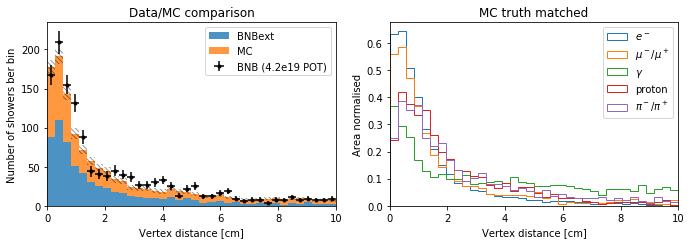

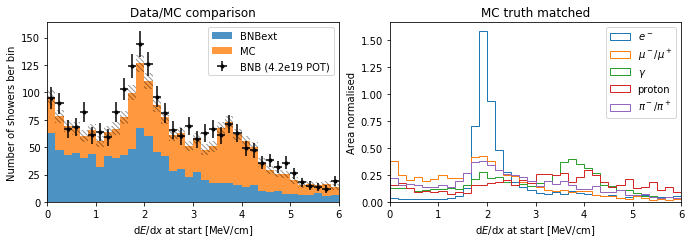

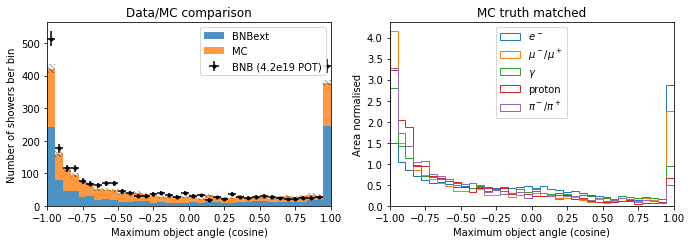

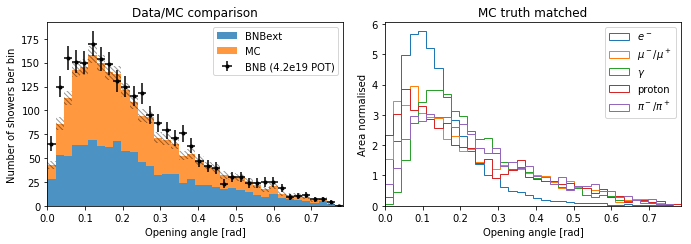

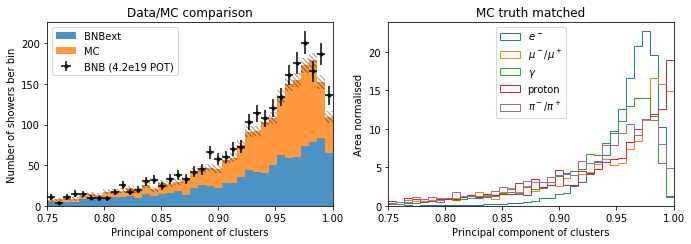

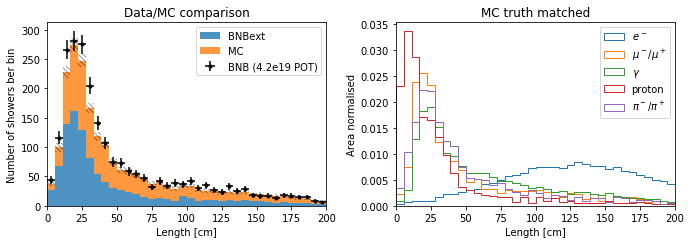

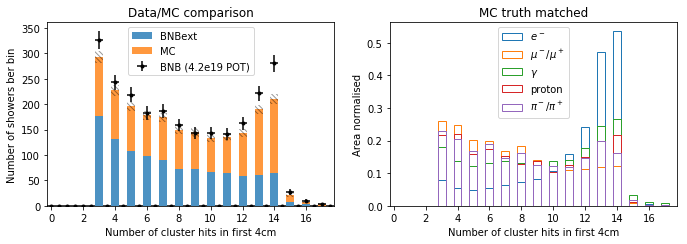

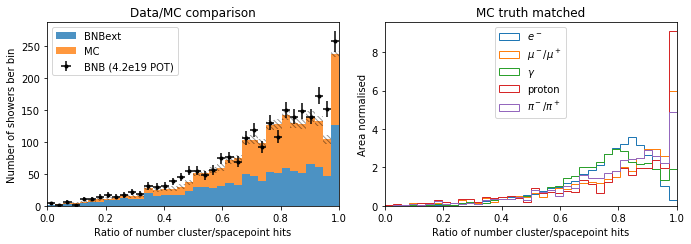

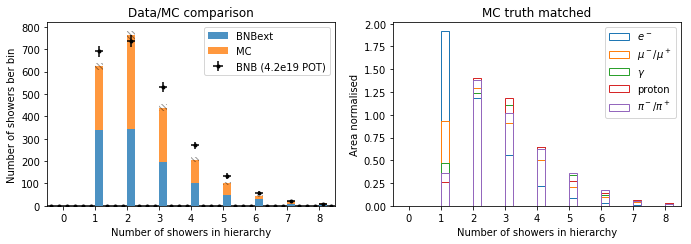

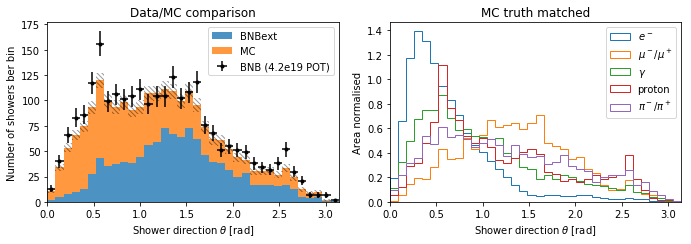

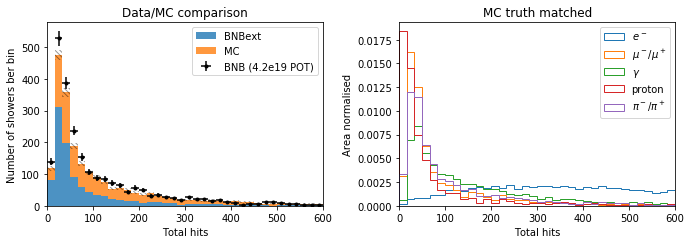

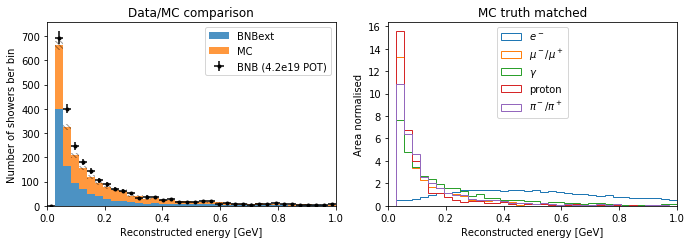

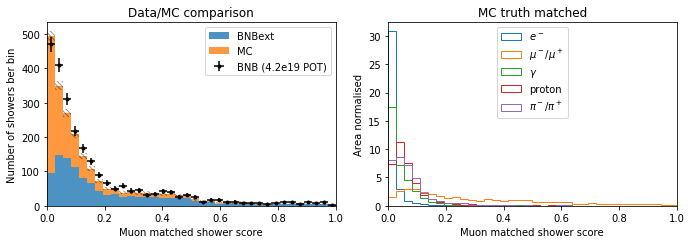

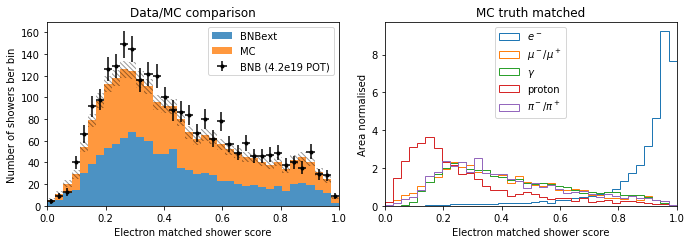

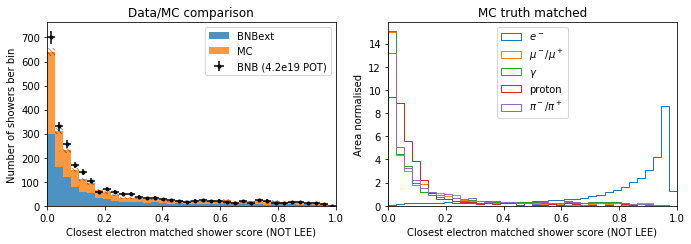

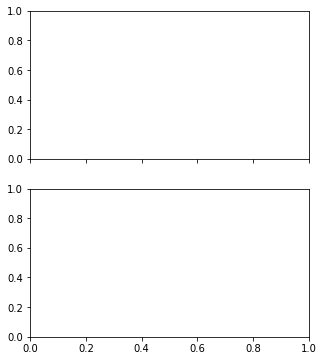

In [30]:
for x_axis,x_lab,min_x,max_x in zip(columns_shower_map,labels,x_axis_min,x_axis_max):
    
    if x_axis=="sh_cle_lee":
        fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(5,6),sharex=True)
    else:
        fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,3.5),sharex=True)
        
    N = 36
    max_y = 38000
    binwidth=(max_x-min_x)/N
    binhalf=binwidth/2

    # MC+BNBext
    df_stacked = [df_sh_bnbext,df_sh_nu]
    scale_stacked = [scale_ext, pot_bnb/pot_nu]
    lab_stacked = ["BNBext","MC"]
    lower_total = 0
    err = [0] * N
    
    for df_stack,lab,scale in zip(df_stacked,lab_stacked,scale_stacked):
        #print(df_stack.columns)
        df_stack = df_stack[df_stack[x_axis].between(min_x,max_x)][[x_axis,"weight","bnbweight"]]
        lower,edges,_ = ax[0].hist(df_stack[x_axis],bins=N,weights=df_stack["weight"], range=(min_x,max_x), stacked=False, fill=True,label=lab,bottom=lower_total,alpha=0.8)
        err += hist_bin_uncertainty(df_stack[x_axis].tolist(),df_stack["bnbweight"].tolist(),edges)*scale
        lower_total+=lower
        
    for this_err,entry,bin_start in zip(err,lower_total,edges[:-1]):
        ax[0].add_patch(patches.Rectangle( (bin_start, entry-this_err), binwidth, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))

    #Data
    data_bnb   = df_sh_bnb[df_sh_bnb[x_axis].between(min_x,max_x)][[x_axis,"weight"]]
    bins,edges = np.histogram(data_bnb[x_axis],bins=N,weights=data_bnb["weight"],range=(min_x,max_x))
    ax[0].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB (4.2e19 POT)")
    
    ax[0].set_ylabel("Number of showers ber bin")
    ax[0].set_xlabel(x_lab)
    ax[0].set_xlim(min_x,max_x)
    ax[0].legend(loc="best")
    ax[0].set_title("Data/MC comparison")
    
    data = df_sh_all[(df_sh_all["shower_cle"]==1) & (df_sh_all["matched_showers_energy"]>-0.5)][x_axis]
    ax[1].hist(data,bins=N,alpha=1.0,range=(min_x,max_x),density=True,label=r"$e^-$",histtype="step", stacked=False, fill=False)
    
    for pid,pid_lab in zip(pid_list[1:],pid_labels[1:]):
        data = df_sh_all[df_sh_all["matched_showers"].isin(pid)][x_axis]
        ax[1].hist(data,bins=N,alpha=1.0,range=(min_x,max_x),density=True,label=pid_lab,histtype="step", stacked=False, fill=False)
    
    #data = df_sh_all[(df_sh_all["shower_cle"]==1) & (df_sh_all["matched_showers_energy"]<0.5)][x_axis]
    #ax[1].hist(data,bins=N,alpha=1.0,range=(min_x,max_x),density=True,label=r"closest $e$, <500MeV",histtype="step", stacked=False, fill=False)
    
    
    ax[1].set_xlabel(x_lab)
    ax[1].set_ylabel("Area normalised")
    
    
    ax[1].set_title("MC truth matched")
    
    if "closest" in x_lab:
        ax[0].set_ylim(0,50)
    if max_x==1 or x_axis == "shower_dedx_hits_w":
        ax[1].legend(loc="upper center")
    else:
        ax[1].legend(loc="best")
        
    plt.tight_layout()
    plt.savefig((output_dir+x_axis+".pdf"))

In [ ]:
import scipy

df_plot = df_sh_nue[df_sh_nue["shower_cle"]==1]
h = sns.jointplot(df_plot["sh_cle_lee"],df_plot["lepton_E"],kind="kde",stat_func=None,n_levels=10,ylim=(0.2,2),size=4)

h.ax_joint.text(0,1.5,"correlation = 0.05")
h.set_axis_labels("Closest electron matched shower score", "Electron true energy [GeV]")

plt.savefig(output_dir+"joint_shower.pdf")

## Check the Preselected data events

In [ ]:
df_sh_bnb[ ((df_sh_bnb["run"]==5328) & (df_sh_bnb["subrun"]== 30) & (df_sh_bnb["event"]==1515)) |
        ((df_sh_bnb["run"]==5513) & (df_sh_bnb["subrun"]==  0) & (df_sh_bnb["event"]==  31)) |
        ((df_sh_bnb["run"]==5187) & (df_sh_bnb["subrun"]==182) & (df_sh_bnb["event"]==9135)) |
        ((df_sh_bnb["run"]==5508) & (df_sh_bnb["subrun"]== 90) & (df_sh_bnb["event"]==4517)) |
        ((df_sh_bnb["run"]==5761) & (df_sh_bnb["subrun"]== 11) & (df_sh_bnb["event"]== 582)) |
        ((df_sh_bnb["run"]==5914) & (df_sh_bnb["subrun"]== 69) & (df_sh_bnb["event"]==3463)) |
        ((df_sh_bnb["run"]==5938) & (df_sh_bnb["subrun"]== 83) & (df_sh_bnb["event"]==4196))
      ][["sh_cle","sh_cle_lee","sh_e","sh_mu","subrun","event","n_showers","n_tracks","shower_energy_w","shower_is_daughter_2"]].head(20)

In [ ]:
df_tr_bnb[ ((df_tr_bnb["run"]==5328) & (df_tr_bnb["subrun"]== 30) & (df_tr_bnb["event"]==1515)) |
        ((df_tr_bnb["run"]==5513) & (df_tr_bnb["subrun"]==  0) & (df_tr_bnb["event"]==  31)) |
        ((df_tr_bnb["run"]==5187) & (df_tr_bnb["subrun"]==182) & (df_tr_bnb["event"]==9135)) |
        ((df_tr_bnb["run"]==5508) & (df_tr_bnb["subrun"]== 90) & (df_tr_bnb["event"]==4517)) |
        ((df_tr_bnb["run"]==5761) & (df_tr_bnb["subrun"]== 11) & (df_tr_bnb["event"]== 582)) |
        ((df_tr_bnb["run"]==5914) & (df_tr_bnb["subrun"]== 69) & (df_tr_bnb["event"]==3463)) |
        ((df_tr_bnb["run"]==5938) & (df_tr_bnb["subrun"]== 83) & (df_tr_bnb["event"]==4196))
      ][["tr_cle","tr_e","tr_mu","subrun","event","n_showers","n_tracks","track_daughter_1","track_energy_w"]].head(20)